# <font color = 'indianred'>**MultiClass Classification with different checkpoints** </font>

**Homework Instructions: Model Performance Comparisons**

---

**Objective:**  
Compare the performance of different model checkpoints on a given task using the provided functions and notebook setup.

---

**Instructions:**

1. **Setup & Initialization:**
    - Start by setting up your environment. Ensure you have all necessary dependencies installed.
    - All functions and required code blocks are pre-written for you.

2. **Experiment 1 - Using DistilBERT:**
    - In the specified code block, set the model checkpoint name to `"distilbert-base-uncased"`.

3. **Experiment 2 - Choosing a New Model:**
    -  Search for a model similar in size to DistilBERT that have a similar or better performance.
    - Get the model check point name from the [Hugging Face Model Hub](https://huggingface.co/models).
    - In this experiment, replace the model checkpoint name with the one you've chosen from the Model Hub.


4. **Experiment 3 - Another Model Choice:**
    - Go back to the [Hugging Face Model Hub](https://huggingface.co/models).
    - Select another model (different from your choice in Experiment 2) with a similar size to DistilBERT.
    - Update the model checkpoint name in the cell for experiment 3.

5. **Conclusion:**
    - Analyze the results of all three experiments.
    - Discuss any differences in performance between the models. What might be causing these differences?
    - Conclude by summarizing your findings and providing insights on which model checkpoint performed best and why.

This notebook has been modified to include functions that allow switching between different pre-trained models for training and evaluation.

## Set Up Environment

In [ ]:
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate -U -qq
    base_folder =  Path("/content/drive/MyDrive/")


from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorWithPadding, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
import evaluate

import torch
from torch.utils.data import DataLoader

import wandb

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import random

import textwrap
import gc

from datasets.utils.logging import disable_progress_bar
disable_progress_bar()

data_folder = base_folder/'data' # CHANGE BASED ON YOUR SETUP
model_folder = base_folder/'models' # CHANGE BASED ON YOUR SETUP
model_folder.mkdir(exist_ok=True)

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.6/519.6 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 87.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 98.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.1/258.1 kB 31.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 104.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.0/190.0 kB 25.7 MB/s eta 0:00:00
     ━━━━

**---------DO NOT CHANGE ANY OF THE FUNCTIONS------------**

## Function to Load Dataset

In [ ]:
def load_custom_dataset(data_path, label_columns_name, text_column_name, class_names=None):
    from datasets import load_dataset
    dataset = load_dataset('csv', data_files=str(data_path))
    selected_columns = {
    'text': dataset['train'][text_column_name],
    'label': dataset['train'][label_columns_name]
    }

    # Create a new dataset with the selected columns
    dataset_selected_columns = Dataset.from_dict(selected_columns)
    dataset_selected_columns.set_format(type='pandas')
    df = dataset_selected_columns[:]
    df['text'] = df['text'].fillna('')
    dataset_selected_columns.reset_format()

    if class_names:
        dataset_selected_columns = dataset_selected_columns.cast_column('label', ClassLabel(names = class_names))

    return dataset_selected_columns


## Function to Split Dataset


In [ ]:
def split_dataset(dataset, train_size, val_size, test_size):
    test_val_splits = dataset.train_test_split(train_size=train_size, seed=42, stratify_by_column='label')
    train_split= test_val_splits['train']
    test_size_new =test_size/(test_size + val_size)
    test_val_splits = test_val_splits['test'].train_test_split(test_size=test_size_new, seed=42, stratify_by_column='label')
    val_split = test_val_splits['train']
    test_split = test_val_splits['test']

    train_val_dataset = DatasetDict({'train': train_split, 'val': val_split})
    test_dataset = DatasetDict({'test': test_split})

    return train_val_dataset, test_dataset


## Function to Create smaller subset

In [ ]:
def get_small_balanced_subset(dataset, num_samples_per_class):
    subset = DatasetDict()

    for split in list(dataset.keys()):
        texts = []
        labels = []
        for label in range(10):
            label_texts = dataset[split].filter(lambda x: x['label'] == label)['text']
            label_subset = random.sample(list(label_texts), num_samples_per_class)
            texts.extend(label_subset)
            labels.extend([label]*len(label_subset))

        subset[split] = Dataset.from_dict({'text': texts, 'label': labels})

    return subset

## Function for Tokenization

In [ ]:
def get_tokenized_dataset(checkpoint, dataset):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    def tokenize_fn(batch):
        # Debug print statements
        # print(f"Type of batch['text']: {type(batch['text'])}")
        # print(f"First item in batch['text']: {batch['text'][0]}")
        return tokenizer(batch["text"], truncation=True)

    tokenized_dataset = dataset.map(tokenize_fn, batched=True)
    return tokenized_dataset


## Function to Create Datasets

In [ ]:
def setup_dataset(data_folder, class_names, num_samples_per_class):

    # Constants for loading and splitting
    data_path = data_folder / 'multiclass_basic_clean.csv'
    label_columns_name = 'Tag_Number_final'
    text_column_name = 'basic_cleaned_text'

    # 1. Load Dataset
    dataset = load_custom_dataset(data_path, label_columns_name, text_column_name, class_names=class_names)

    # 2. Split Dataset
    train_val_dataset, test_dataset = split_dataset(dataset, train_size=0.6, val_size=0.2, test_size=0.2)

    # 3. Get Small Balanced Subset
    train_val_subset = get_small_balanced_subset(train_val_dataset, num_samples_per_class=num_samples_per_class)

    return train_val_subset, train_val_dataset, test_dataset



## Function to Initialize Model

In [ ]:
def initialize_model(checkpoint, class_names):
    config = AutoConfig.from_pretrained(checkpoint)
    id2label = {}
    for id_, label_ in enumerate(class_names):
        id2label[str(id_)] = label_

    label2id = {}
    for id_, label_ in enumerate(class_names):
        label2id[label_] = id_

    config.id2label = id2label
    config.label2id = label2id

    model = AutoModelForSequenceClassification.from_pretrained(checkpoint, config=config)
    return model

## Function to Compute Metrics

In [ ]:
def compute_metrics(eval_pred):

    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)

    f1_metric = evaluate.load("f1", average="macro")
    accuracy = evaluate.load("accuracy")

    evaluations = {}
    evaluations.update(f1_metric.compute(predictions=predictions, references = labels, average="macro"))
    evaluations.update(accuracy.compute(predictions=predictions, references = labels))

    return evaluations

## Function to set Trainer

In [ ]:
def get_trainer(model, training_args, train_dataset, eval_dataset, compute_metrics, tokenizer, data_collator):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator= data_collator
    )
    return trainer

## Function to plot confusion matrix

In [ ]:
def log_and_plot_confusion_matrix(trainer, tokenized_val_dataset, class_names):
    # Perform prediction using the trainer
    valid_output = trainer.predict(tokenized_val_dataset)

    # Extract the predicted labels and true labels
    valid_preds = np.argmax(valid_output.predictions, axis=1)
    valid_labels = np.array(valid_output.label_ids)

    # Log the confusion matrix to wandb
    wandb.log({
        "conf_mat": wandb.plot.confusion_matrix(
            preds=valid_preds,
            y_true=valid_labels,
            class_names=class_names
        )
    })

    # Plot the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_true=valid_labels,
        y_pred=valid_preds,
        ax=ax,
        normalize="true",
        display_labels=class_names,
        xticks_rotation=90
    )
    plt.show()

## Function to free memory

In [ ]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()


## Function to tokenize dataset and, train and eval models

<font color = 'indianred'>**ALLOWED TO CHANGE THE BLOCK IN THE FUNCTION BELOW**

In [ ]:
def tokenize_train_evaluate_log(training_args, checkpoint, base_folder,
                             class_names, train_val_subset, compute_metrics):
    # 1. Free memory
    free_memory()

    # 2. Setup wandb
    wandb.login()
    %env WANDB_PROJECT = nlp_Part-B-Colab

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################

    # MAKE SURE THE BASE FOLDER IS SETUP CORRECTLY
    #  YOU CAN CHANGE THIS LINE IF YOU WANT TO SAVE IN A DIFFERENT FOLDER

    model_folder = base_folder/'stack/checkpoint'
    model_folder.mkdir(exist_ok=True, parents=True)

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################


    # 3. Get Tokenized Dataset and Data Collator
    train_val_tokenized_dataset = get_tokenized_dataset(checkpoint, train_val_subset)

    # 4. Initialize Model and Tokenizer
    model = initialize_model(checkpoint, class_names)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # 5. Initialize Trainer
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = get_trainer(model, training_args, train_val_tokenized_dataset['train'],
                          train_val_tokenized_dataset['val'], compute_metrics, tokenizer, data_collator)

    # 6. Train and Evaluate
    trainer.train()
    trainer.evaluate(train_val_tokenized_dataset['val'])

    # 7. Log Metrics and Plot
    log_and_plot_confusion_matrix(trainer, train_val_tokenized_dataset['val'], class_names)

    best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
    wandb.log({"best_model_checkpoint_step": best_model_checkpoint_step})
    print(f"The best model was saved at step {best_model_checkpoint_step}.")

    wandb.finish()

## Initial Training Arguments

DO NOT CHANGE ANY ARGUMENTS

In [ ]:
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="accuracy",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher
    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'exp1',  # Experiment name for Weights & Biases
)

# Experiments

## Dataset hyperparameters

In [ ]:
class_names = ['c#', 'java', 'php','javascript', 'android', 'jquery', 'c++',  'python', 'iphone', 'asp.net']
num_samples_per_class = 200
train_val_subset, train_val_dataset, test_dataset = setup_dataset(data_folder, class_names, num_samples_per_class)

## Experiment 1 : distilbert-base-uncased

### Trainer hyperparameters

In [ ]:
checkpoint = "distilbert-base-uncased"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{num_samples_per_class}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1711: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=nlp_course_fall_2023-HW5-Part-B-Colab


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'pre_classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wandb: Currently logged in as: akshat_patil. Use `wandb login --relogin` to force relogin


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1,Accuracy
20,2.295100,2.258021,0.111435,0.183000
40,2.198800,2.130382,0.179091,0.252500
60,2.080900,1.901952,0.614296,0.615000
80,1.834200,1.656346,0.697051,0.697000
100,1.660300,1.457665,0.729706,0.727000
120,1.450500,1.304964,0.757750,0.751500
140,1.331400,1.192971,0.746181,0.748500
160,1.159400,1.094212,0.767168,0.767500
180,1.138100,1.032359,0.785112,0.782500
200,1.041000,0.988094,0.796095,0.793500


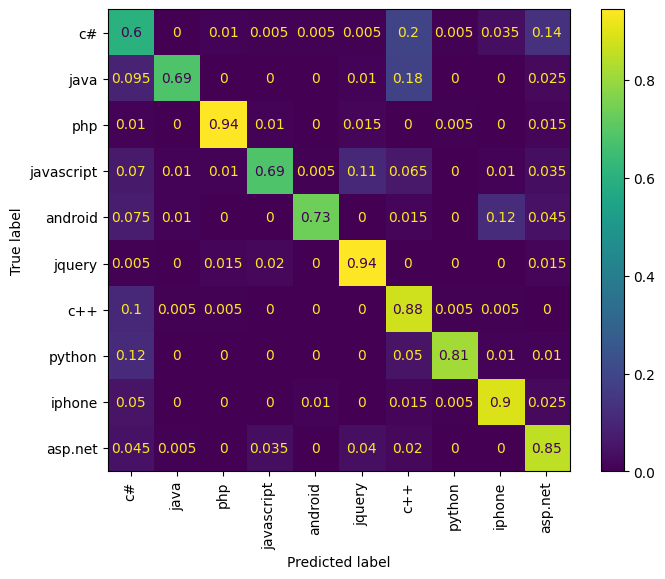

The best model was saved at step 240.


eval/accuracy,▁▂▆▇▇▇▇██████
eval/f1,▁▂▆▇▇▇▇██████
eval/loss,█▇▆▅▄▃▂▂▁▁▁▁▁
eval/runtime,▁▅█▆▆▇█▇▇▇▇▇▇
eval/samples_per_second,█▄▁▃▃▂▁▂▂▂▂▂▂
eval/steps_per_second,█▄▁▃▃▂▁▂▂▂▂▂▂
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇██████
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁
train/loss,█▇▇▅▄▃▃▂▂▁▁▁
train/total_flos,▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

## Experiment 2 : Your choice of checkpoint

### Trainer hyperparameters

In [ ]:
checkpoint =  "distilroberta-base"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{num_samples_per_class}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)


env: WANDB_PROJECT=nlp_course_fall_2023-HW5-Part-B-Colab


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1,Accuracy
20,2.303100,2.277723,0.085767,0.192500
40,2.193000,2.068666,0.126406,0.234500
60,1.977800,1.728509,0.352879,0.411000
80,1.633100,1.354726,0.640674,0.663500
100,1.354300,1.085393,0.774185,0.776500
120,1.121200,0.912340,0.805482,0.804500
140,0.953300,0.821603,0.794635,0.802500
160,0.848000,0.737735,0.825509,0.827500
180,0.827500,0.696820,0.836267,0.836000
200,0.755900,0.654381,0.842935,0.843500


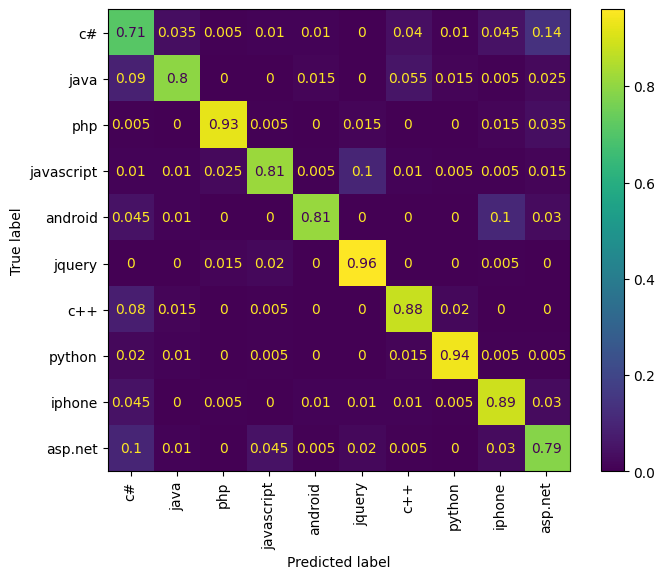

The best model was saved at step 240.


eval/accuracy,▁▁▃▆▇█▇██████
eval/f1,▁▁▃▆▇█▇██████
eval/loss,█▇▆▄▃▂▂▁▁▁▁▁▁
eval/runtime,█▁▁▂▂▄▆▄▃▅▃▅▇
eval/samples_per_second,▁██▇▇▅▃▅▆▄▆▄▂
eval/steps_per_second,▁██▇▇▅▃▅▆▄▆▄▂
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇██████
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁
train/loss,██▇▅▄▃▂▂▂▁▁▁
train/total_flos,▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

## Experiment 3 -  Your second choice of checkpoint here

### Trainer hyperparameters

In [ ]:
checkpoint = "giganticode/bert-base-StackOverflow-comments_2M"
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}-{num_samples_per_class}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1711: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


env: WANDB_PROJECT=nlp_course_fall_2023-HW5-Part-B-Colab


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at giganticode/bert-base-StackOverflow-comments_2M and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,F1,Accuracy
20,2.318500,2.237740,0.132249,0.174500
40,2.202300,2.130431,0.207256,0.257500
60,2.002300,1.836456,0.386313,0.459000
80,1.778500,1.597830,0.608730,0.636000
100,1.532500,1.321570,0.779952,0.785500
120,1.284000,1.110059,0.831090,0.831000
140,1.108500,0.966180,0.841272,0.844000
160,0.955500,0.875846,0.841130,0.843000
180,0.919500,0.790409,0.848540,0.849000
200,0.800600,0.742017,0.855741,0.856500


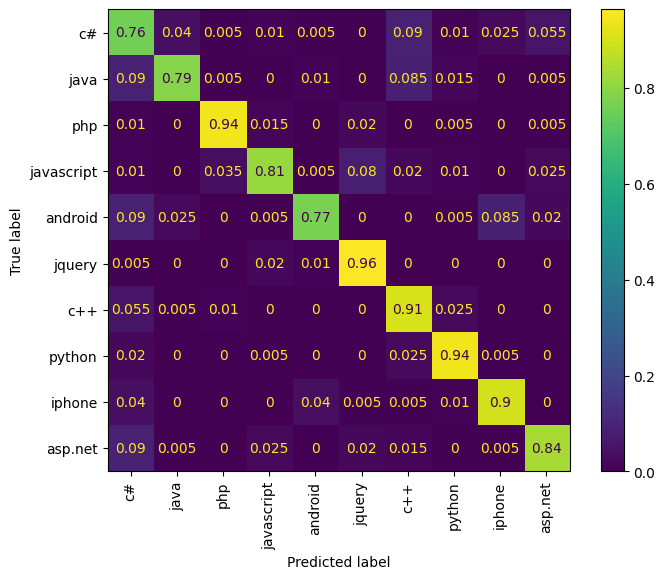

The best model was saved at step 240.


eval/accuracy,▁▂▄▆▇████████
eval/f1,▁▂▃▆▇████████
eval/loss,██▆▅▄▃▂▂▁▁▁▁▁
eval/runtime,▂▃▁▃▅▂▃▁▃▁▃▁█
eval/samples_per_second,▇▆█▆▄▇▆█▆█▆█▁
eval/steps_per_second,▇▆█▆▄█▆█▆█▆█▁
train/epoch,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇████
train/global_step,▁▁▂▂▂▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▇▇██████
train/learning_rate,█▇▇▆▅▅▄▄▃▂▂▁
train/loss,█▇▇▆▄▃▃▂▂▁▁▁
train/total_flos,▁


In [ ]:
tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

# Conclusion
Below are the eval accuracy of the 3 models,all the below models were trained on only 200 samples and evaluated on the same.

*   Experiment 1: distilbert-base-uncased - This model achieved an accuracy of 0.804 in the evaluation. It is based on the DistilBERT architecture, which is a distilled and lighter version of the original BERT model. This model performed the worst among the three.

*   Experiment 2: distilroberta-base - The second experiment used the distilroberta-base model, which is also a lighter version of the RoBERTa model. It achieved an accuracy of 0.8505, which is a moderate improvement compared to Experiment 1 but still not the best.
*   Experiment 3: giganticode/bert-base-StackOverflow-comments_2M - The third experiment utilized the giganticode/bert-base-StackOverflow-comments_2M model, which achieved the highest accuracy of 0.8635.

The performance difference between the models in Experiments 1, 2, and 3 can be attributed to various factors such as model complexity, training data, fine-tuning, hyperparameters, and data specificity.

Experiment 3's BERT-based model with extensive training data, effective fine-tuning, and possible domain-specific advantages outperformed the distilled models in Experiments 1 and 2.

The choice of the best-performing model depends on the task requirements, available resources, and the balance between accuracy and model complexity.

Interestingly, Experiment 2's distilroberta-base model achieved performance close to Experiment 3's giganticode/bert-base-Stack Overflow-comments_2M model, suggesting that smaller models can also achieve high accuracy without sacrificing much performance.

Therefore, model selection should consider a trade-off between accuracy and computational efficiency, and sometimes, a simpler model may be sufficient for the task at hand.